# Cleaning data and the skies

## Background
Your are a data analyst at an environmental company. Your task is to evaluate ozone pollution across various regions.

You’ve obtained data from the U.S. Environmental Protection Agency (EPA), containing daily ozone measurements at monitoring stations across California. However, like many real-world datasets, it’s far from clean: there are missing values, inconsistent formats, potential duplicates, and outliers.

Before you can provide meaningful insights, you must clean and validate the data. Only then can you analyze it to uncover trends, identify high-risk regions, and assess where policy interventions are most urgently needed.

# Daily Ozone Measurements in California
This report explores daily maximum 8-hour ozone concentrations across California, using 2024 data from the U.S. EPA. The objective is to identify temporal patterns, geographic disparities, and potential influences from monitoring methods and human activity. Below are the key insights:

- **Seasonal Trends**:  
  Ozone levels are highest during summer months, particularly **July**, likely due to increased sunlight driving ozone formation.

- **Geographic Disparities**:  
  Southern and inland counties (e.g., **Los Angeles**, **Kern**, **Tulare**) show consistently higher ozone levels, while coastal counties (e.g., **Santa Barbara**, **Sonoma**) exhibit lower concentrations.

- **Methodological Variance**:
  - **Method Code 87**: Most commonly used; showed moderate variability.
  - **Method Code 47**: Produced the most consistent results, but included some extreme outliers.
  - **Method Code 53**: Showed the highest variability, but was limited to **Tulare County**, reducing generalizability.

- **Urban Activity Effects**:  
  No major difference was found between weekdays and weekends overall. However, in a subset of 10 counties, a slight midweek peak (Monday–Thursday) followed by a decline through Sunday was observed.

- **Geospatial Patterns**:  
  A heatmap of California monitoring sites visually reinforces that **ozone pollution intensifies in Southern and inland regions**.
 

## The data
The data is a modified dataset from the U.S. Environmental Protection Agency ([EPA](https://www.epa.gov/outdoor-air-quality-data/download-daily-data)). 

#### Ozone contains the daily air quality summary statistics by monitor for the state of California for 2024. Each row contains the date and the air quality metrics per collection method and site
- "Date" - the calendar date with which the air quality values are associated
- "Source" - the data source: EPA's Air Quality System (AQS), or Airnow reports
- "Site ID" - the id for the air monitoring site
- "POC" - the id number for the monitor
- "Daily Max 8-hour Ozone Concentration" - the highest 8-hour value of the day for ozone concentration
- "Units" - parts per million by volume (ppm)
- "Daily AQI Value" - the highest air quality index value for the day, telling how clean or polluted the air is (a value of 50 represents good air quality, while a value above 300 is hazardous)
- "Local Site Name" - name of the monitoring site
- "Daily Obs Count" - number of observations reported in that day
- "Percent Complete" - indicates whether all expected samples were collected
- "Method Code" - identifier for the collection method
- "CBSA Code" - identifier for the core base statistical area (CBSA)
- "CBSA Name" - name of the core base statistical area
- "State FIPS Code" - identifier for the state
- "State" - name of the state
- "County FIPS Code" - identifer for the county
- "County" - name of the county
- "Site Latitude" - latitude coordinates of the site
- "Site Longitude" - longitude coordinates of the side

In [3]:
import pandas as pd
ozone = pd.read_csv('data/ozone.csv')
ozone

,Date,Source,Site ID,POC,Daily Max 8-hour Ozone Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,Method Code,CBSA Code,CBSA Name,County FIPS Code,County,Site Latitude,Site Longitude
0,/2024,AQS,60010007,1,0.031,ppm,29.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
1,01/02/2024,AQS,60010007,1,0.037,ppm,34.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
2,/2024,AQS,60010007,1,NaN,ppm,30.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
3,January 04/2024,AQS,60010007,1,0.026,ppm,24.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
4,January 05/2024,AQS,60010007,1,0.027,ppm,25.0,Livermore,17,100.0,47.0,41860.0,"San Francisco-Oakland-Hayward, CA",1,Alameda,37.687526,-121.784217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54754,02/16/2024,AQS,60710005,1,0.044,ppm,41.0,Crestline,17,100.0,87.0,40140.0,"Riverside-San Bernardino-Ontario, CA",71,San Bernardino,34.243100,-117.272350
54755,August 14/2024,AQS,60270101,1,0.057,ppm,58.0,Death Valley NP - Park Village,17,100.0,87.0,13860.0,"Bishop, CA",27,Inyo,36.508611,-116.847778
54756,June 30/2024,AQS,60690002,1,NaN,ppm,29.0,Hollister,17,100.0,47.0,41940.0,"San Jose-Sunnyvale-Santa Clara, CA",69,San Benito,36.843425,-121.362100
54757,/2024,AQS,61072010,1,0.058,ppm,61.0,Porterville,17,100.0,199.0,47300.0,"Visalia-Porterville, CA",107,Tulare,36.031831,-119.055018


## Competition challenge

Create a report that covers the following:
1. Your EDA and data cleaning process.
2. How does daily maximum 8-hour ozone concentration vary over time and regions?
3. Are there any areas that consistently show high ozone concentrations? Do different methods report different ozone levels?
4. Consider if urban activity (weekend vs. weekday) has any affect on ozone levels across different days.
5. Bonus: plot a geospatial heatmap showing any high ozone concentrations.

# Data Cleaning


We run `dtypes` do check the data types within the dataset

In [36]:
# turn the ozone dataset into a DataFrame
df = pd.DataFrame(ozone)

# identify the kind of data types we're working with 
df.dtypes


Date                                     object
Source                                   object
Site ID                                   int64
POC                                       int64
Daily Max 8-hour Ozone Concentration    float64
Units                                    object
Daily AQI Value                         float64
Local Site Name                          object
Daily Obs Count                           int64
Percent Complete                        float64
Method Code                             float64
CBSA Code                               float64
CBSA Name                                object
County FIPS Code                          int64
County                                   object
Site Latitude                           float64
Site Longitude                          float64
dtype: object

The `Date` contains three different formats: 
- /2024
- 01/02/2024
- Janurary 04/2024

It appeared that the days are in chronological order and incremented by 1 day 

In [5]:
df['Date'].head(20)

0               /2024
1          01/02/2024
2               /2024
3     January 04/2024
4     January 05/2024
5     January 06/2024
6          01/07/2024
7               /2024
8               /2024
9     January 10/2024
10    January 11/2024
11    January 12/2024
12         01/13/2024
13         01/14/2024
14         01/15/2024
15              /2024
16         01/17/2024
17         01/18/2024
18         01/19/2024
19              /2024
Name: Date, dtype: object

The dates were fixed by:
- Loop through each row
- Whenever a "/2024" value was detected, it was replaced by adding 1 day to the previous valid date
- The entire `Date` column was then converted to a `datetime` format

In [6]:
df['Date'].head(20)

# import timedelta so we can use this function for previous day calculation
from datetime import timedelta

# upon closer inspection, we see that every occurrence of "/2024" is the day after its previous row
# for example: Janurary 06/2024 goes to 01/07/2024 and then "/2024"
# this means we need to select every occurrence of "/2024" and set it to the previous row's date and add 1 

previous_date = None

# loop through each row
for i in range(1, len(df)):
    if df.loc[i, 'Date'] == '/2024': # if a cell inside the Date column is '/2024'
        prev_date = pd.to_datetime(df.loc[i - 1, 'Date']) # set the previous day to be the current cell's position - 1 and convert to datetime
        df.loc[i, 'Date'] = (prev_date + timedelta(days = 1)).strftime('%m/%d/%y') # set the current cell's value previous date's value + 1 and format 

# convert the whole date column to datetime 
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].head(20)


0    2024-01-01
1    2024-01-02
2    2024-01-03
3    2024-01-04
4    2024-01-05
5    2024-01-06
6    2024-01-07
7    2024-01-08
8    2024-01-09
9    2024-01-10
10   2024-01-11
11   2024-01-12
12   2024-01-13
13   2024-01-14
14   2024-01-15
15   2024-01-16
16   2024-01-17
17   2024-01-18
18   2024-01-19
19   2024-01-20
Name: Date, dtype: datetime64[ns]

The data set was checked for total null values for each column

In [7]:
# check the total null values for each column
df.isnull().sum()

Date                                       0
Source                                     0
Site ID                                    0
POC                                        0
Daily Max 8-hour Ozone Concentration    2738
Units                                      0
Daily AQI Value                         2738
Local Site Name                            0
Daily Obs Count                            0
Percent Complete                           0
Method Code                             6490
CBSA Code                               2408
CBSA Name                               2408
County FIPS Code                           0
County                                     0
Site Latitude                              0
Site Longitude                             0
dtype: int64

The `Daily Max 8-hour Ozone Concentration` column had a substantial amount of null values. This column is essential to answering all our questions. Thus, we dropped any row with a null value

In [8]:
df = df.dropna(subset = ['Daily Max 8-hour Ozone Concentration'])

# Exploratory Data Analysis (EDA)
---

## How does daily maximum 8-hour ozone concentration vary over time and regions? ###


We analyze the `Daily Max 8-hour Ozone Concentration` column with respect over `Date` and `County` values

In [24]:
# analyze the daily max 8 hour ozone concentration over time (Date) and regions (County)
# we will be using County to represent region because the other columns are numeric values, thus making it hard to comprehend 

# determine how many unique counties are in the dataset. This returns 50. 
df['County'].nunique()

# retrieve the top 10 counties by how often they appear (row count)
top_counties = df['County'].value_counts().head(10).index

# filter the original dataframe to only have the counties in the top 10
df_top_10_months = df[df['County'].isin(top_counties)]

# by default, when we run dt.month_name(), this will extract and sort the month in alphabetical order
# we want them to be in chronological order (Jan, Feb, Mar, etc)
# we will have to categorize them
df_top_10_months['Month'] = pd.Categorical(df_top_10_months['Date'].dt.strftime('%B'), categories = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered = True)

# average concentration over time and county
df_top_10_months = df_top_10_months.groupby(['Month', 'County'])['Daily Max 8-hour Ozone Concentration'].mean().reset_index()

df_top_10_months


Utilize a line plot to show change in average ozone concnetration over time throughout the top 10 counties (based on their total number of measurements)

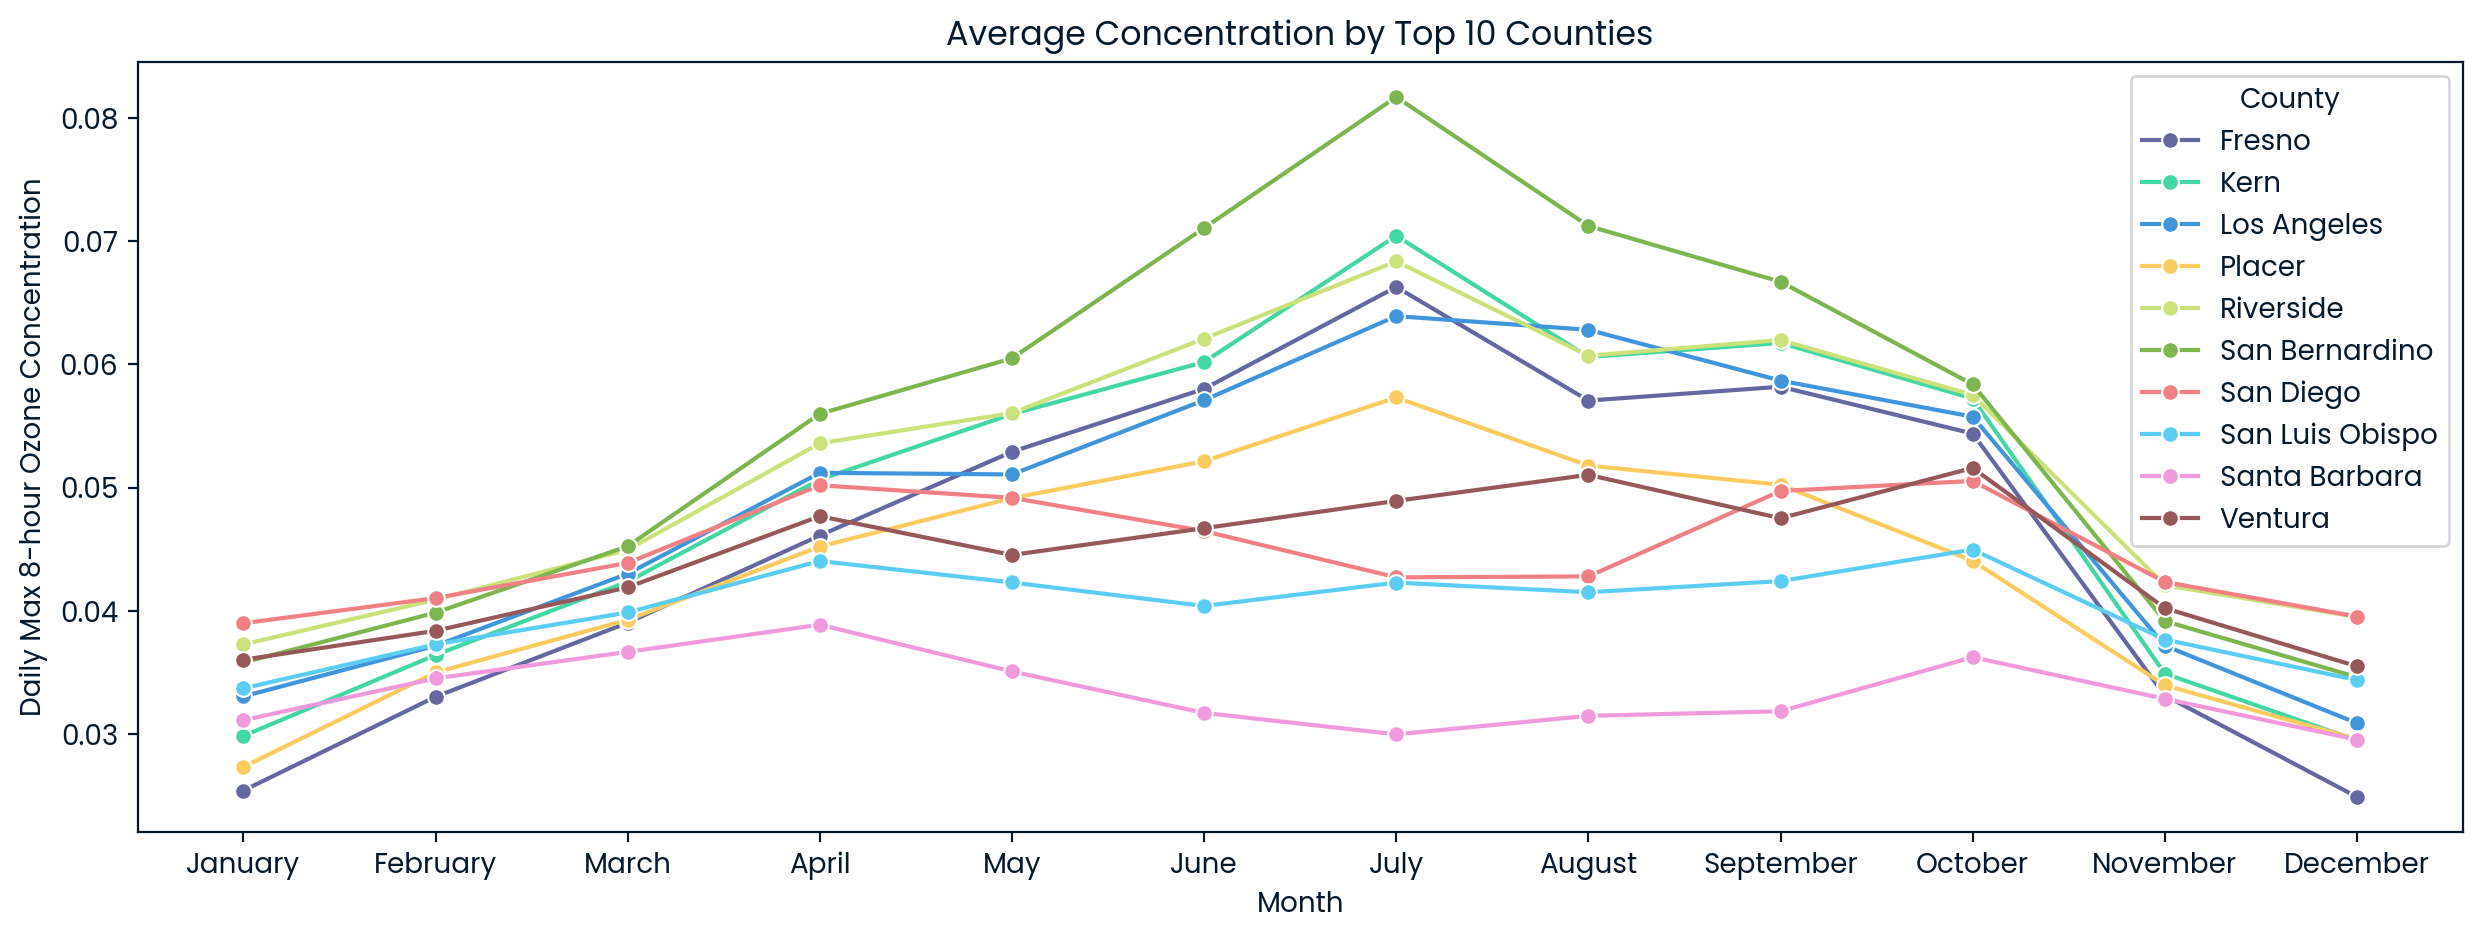

In [25]:
# use a line plot to showcase the average ozone concentrations over time/counties 
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize = (15, 5))
sns.lineplot(data = df_top_10_months, x = 'Month', y = 'Daily Max 8-hour Ozone Concentration', hue = 'County', marker = 'o')
plt.title('Average Concentration by Top 10 Counties')
plt.show()


### Key insights: 
- Most counties tend to experience higher ozone concentrations during warmer months (i.e. San Bernadino peaks in July with an average ozone concentration of approximately 0.08ppm). Ozone concentrations typically increase with sunlight
- Some counties (i.e. San Diego, San Luis Obispo, Santa Barbara) did not follow the trend of higher ozone concentrations during warmer months. This could be potentially due to their proximity to the ocean. Things like sea breezes, coastal winds, and lower overall temperatures can play a part in this
- Higher ozone concentrations could indicate higher AQI values (higher AQI = bad). 

## Are there any areas that consistently show high ozone concentrations? ##

Plot the distribution of daily maxium 8-hour ozone concnetrations for each county 


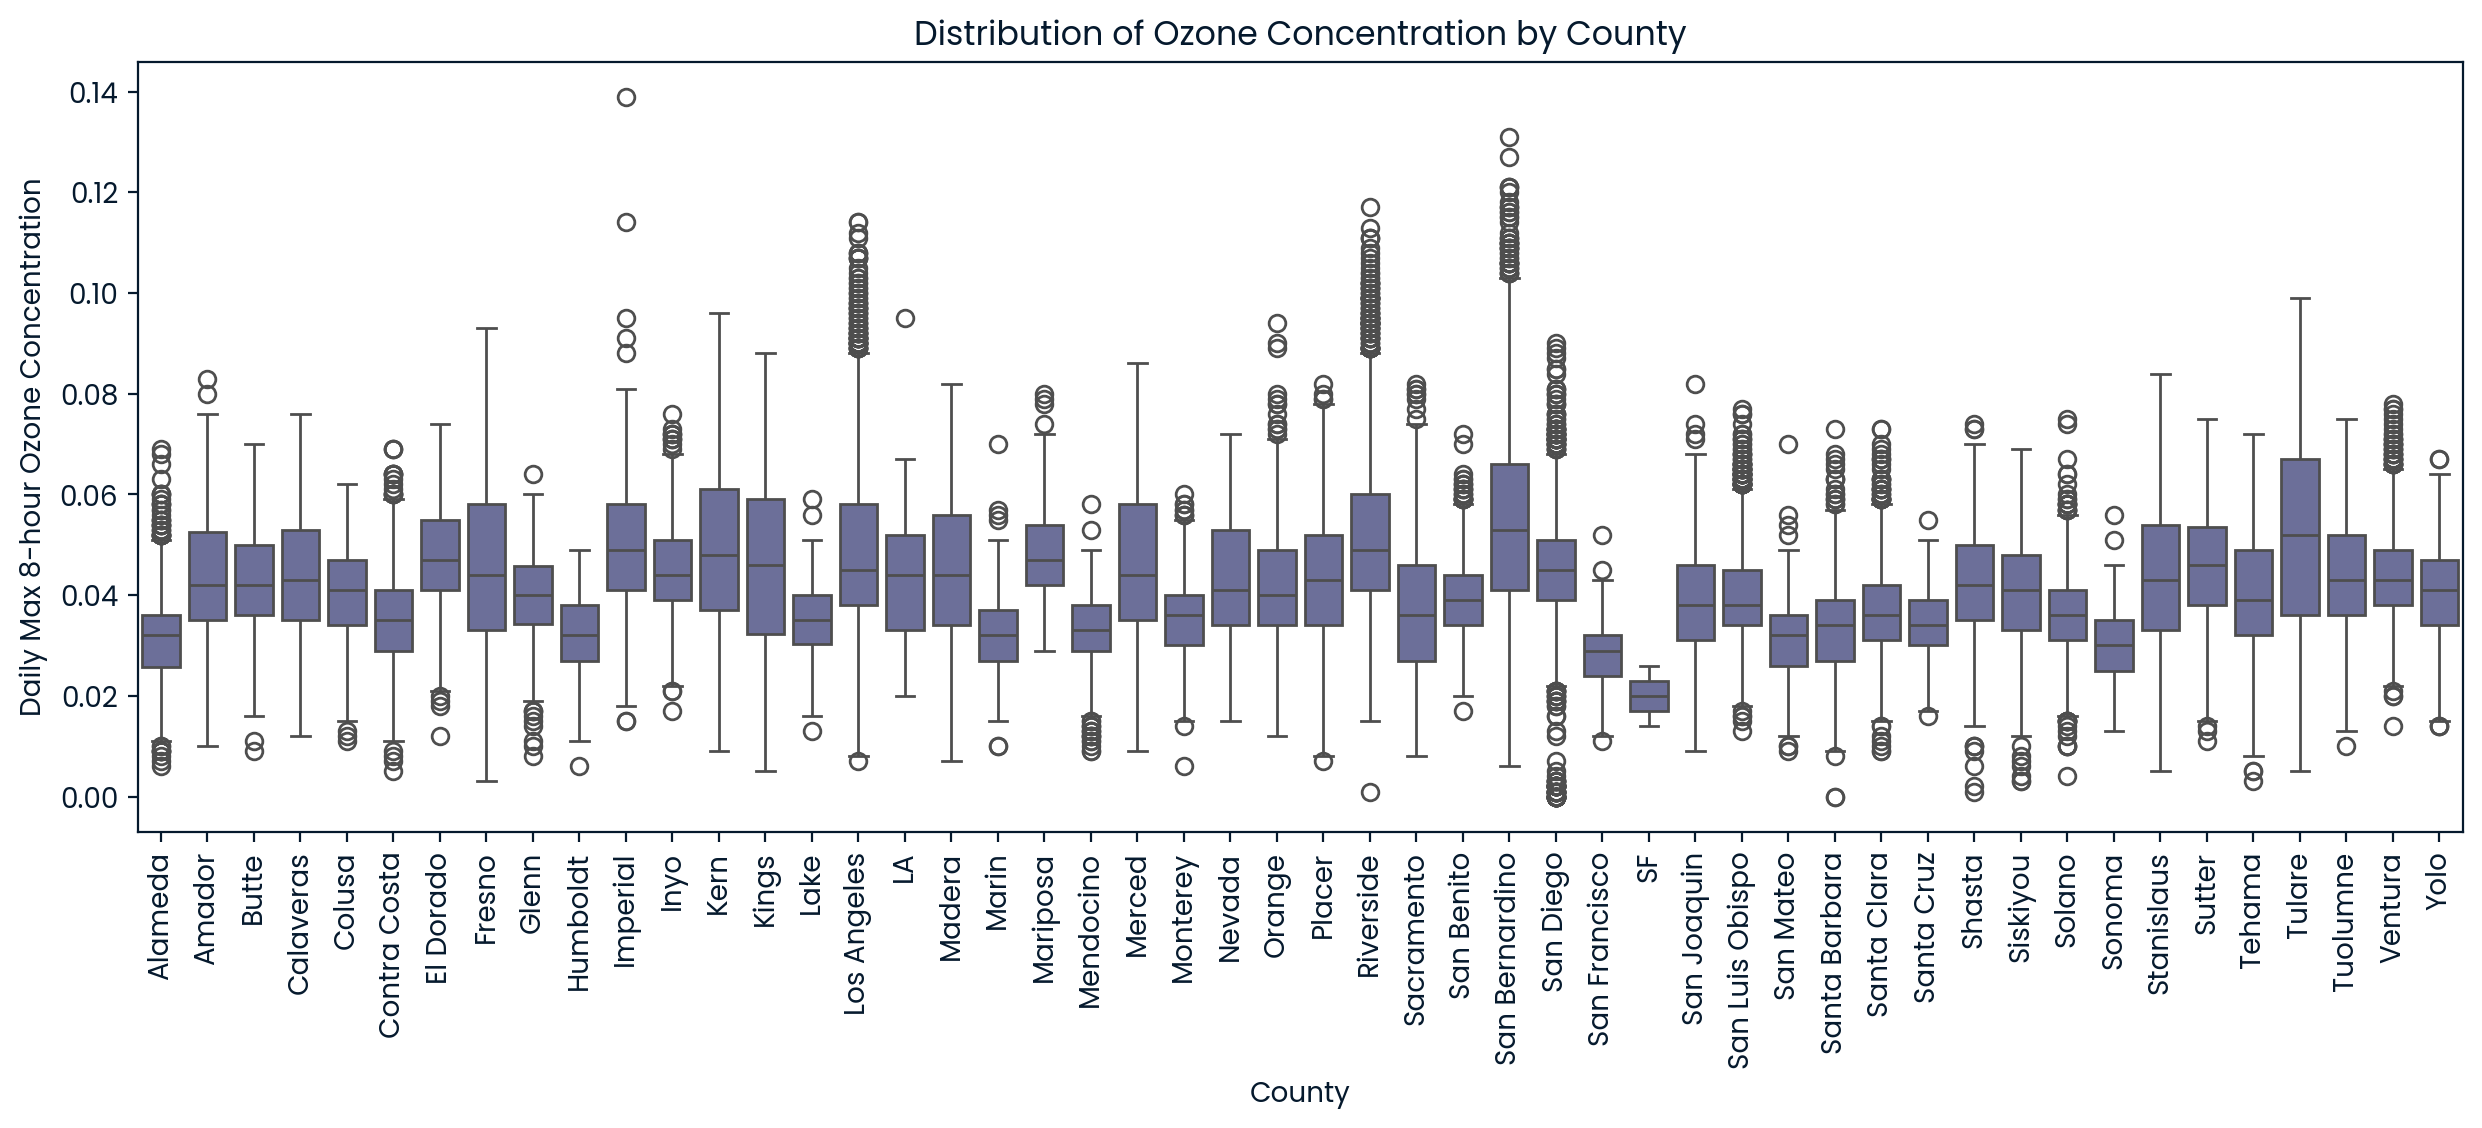

In [10]:
# use a boxplot to show variance between ALL counties and ozone concentration
plt.figure(figsize = (15, 5))
sns.boxplot(data = df, x = 'County', y = 'Daily Max 8-hour Ozone Concentration')
plt.xticks(rotation = 90)
plt.title('Distribution of Ozone Concentration by County')
plt.show()

### Key Insights:
- Counties like Riverside, Los Angeles, San Bernardino have high median values, high IQR boxes, and many high outliers. This may suggest that there are frequent extreme concentrations and high variability
- Counties like Kern and Tulare have high median values and high IQR boxes, but no outliers. This may suggest that the variation is consistent and contained within the IQR values
- It is also worth noting (refer to previous code) that the number of recorded ozone concentrations is less in Kern and Tulare, and higher in Riverside, Los Angeles, and San Bernadino. This may explain the presence/absence of outliers 

## Do different methods report different ozone levels? ##

Analyze the potential relationship between `Method Code` and `Daily Max 8-hour Ozone Concentration`

In [20]:
# drop null values for method code column
df_methods = df.dropna(subset = ['Method Code'])

# count how many measurements were taken for each method code 
df_methods.groupby('Method Code')['Daily Max 8-hour Ozone Concentration'].count()

Method Code
47.0      8108
53.0       373
87.0     33510
199.0     3842
Name: Daily Max 8-hour Ozone Concentration, dtype: int64

Utilize a boxplot to display key metrics such as Interquartile Range (IQR) and outliers 

Text(0.5, 1.0, 'Ozone Concentration by Method Code')

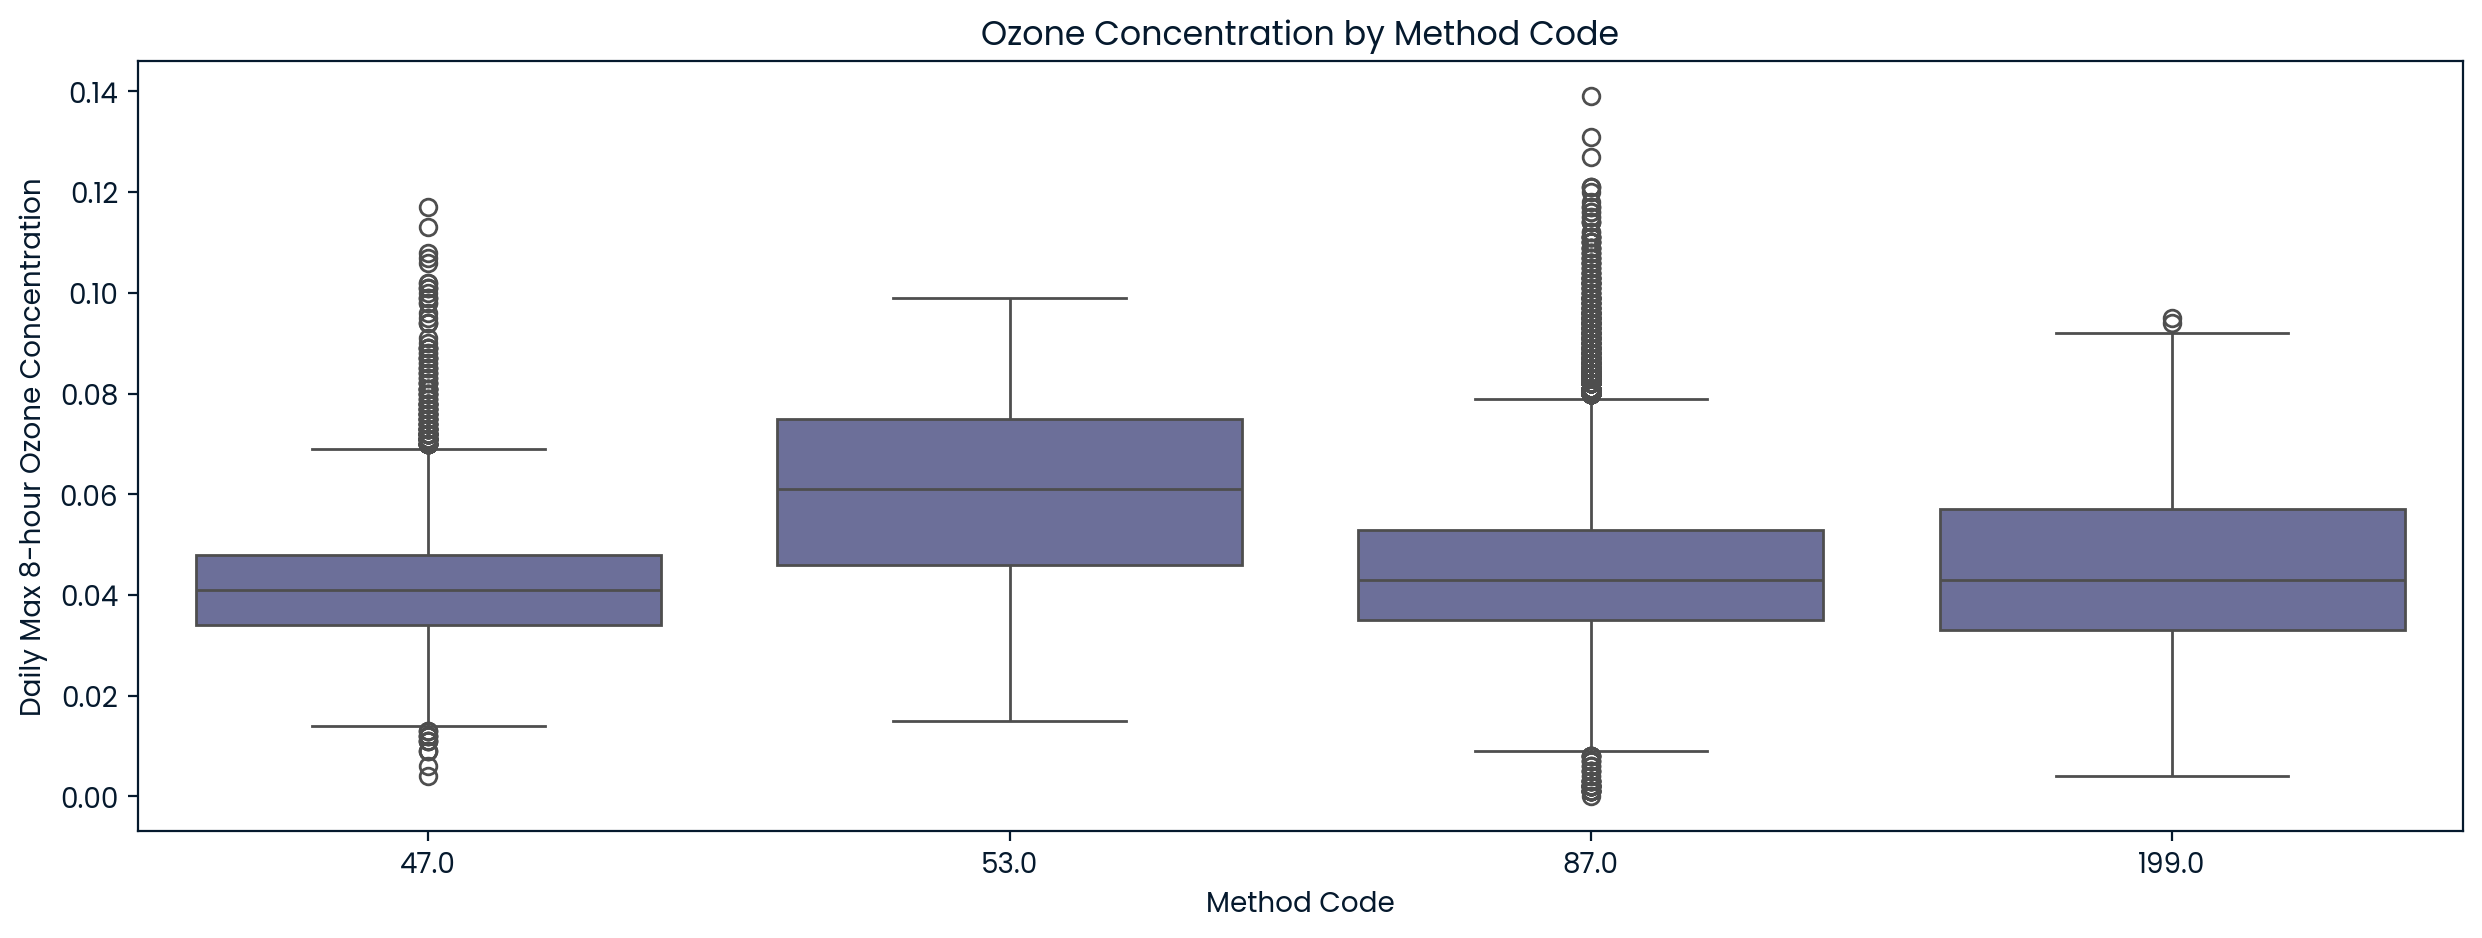

In [22]:
# use a boxplot to show distribution of ozone concentration measurements per each method code
plt.figure(figsize = (15, 5))
sns.boxplot( data = df_methods, x = 'Method Code', y = 'Daily Max 8-hour Ozone Concentration')
plt.title('Ozone Concentration by Method Code')

### Key Insights:
- Method code 87 is by far the most common, offering a braoder sample size across counties
- Method code 47 has the narrowest IQR which may suggest more consistent ozone concentration measurements. However, it does contain a notable amount of outliers below 0.02 and above 0.07
- Method code 53 has the widest IQR which may suggest more variability in ozone concentration measurements. There are no outliers. However, it is worth noting that this method code appears only in Tulare county with a total of 373 records. This limits how broadly we can compare it to others
- Method code 87 has moderate IQR margins with notable outliers below 0.02 and above 0.08

## Consider if urban activity (weekend vs. weekday) has any affect on ozone levels across different days ##

Categorize measurements into either True for `Weekend` or False to compare weekend vs weekday ozone measurements

In [30]:
# to analyze weekday vs weekend activity, must first extract the days of the weeks from the date column
df['Day Of Week'] = df['Date'].dt.day_name()

# categorize the days into a boolean column. We want true for weekend (Sat, Sun) and false for weekday (not Sat, Sun)
df['Weekend'] = df['Day Of Week'].isin(['Saturday', 'Sunday'])

# group by weekend and use describe() to output stuff like row count and mean
df_weekend = df.groupby('Weekend')['Daily Max 8-hour Ozone Concentration'].describe()
df_weekend

,count,mean,std,min,25%,50%,75%,max
Weekend,,,,,,,,
False,37125.0,0.043630,0.014848,0.0,0.034,0.041,0.052,0.139
True,14896.0,0.043243,0.013996,0.0,0.034,0.041,0.051,0.114


Text(0.5, 1.0, 'Ozone Concentration by Day')

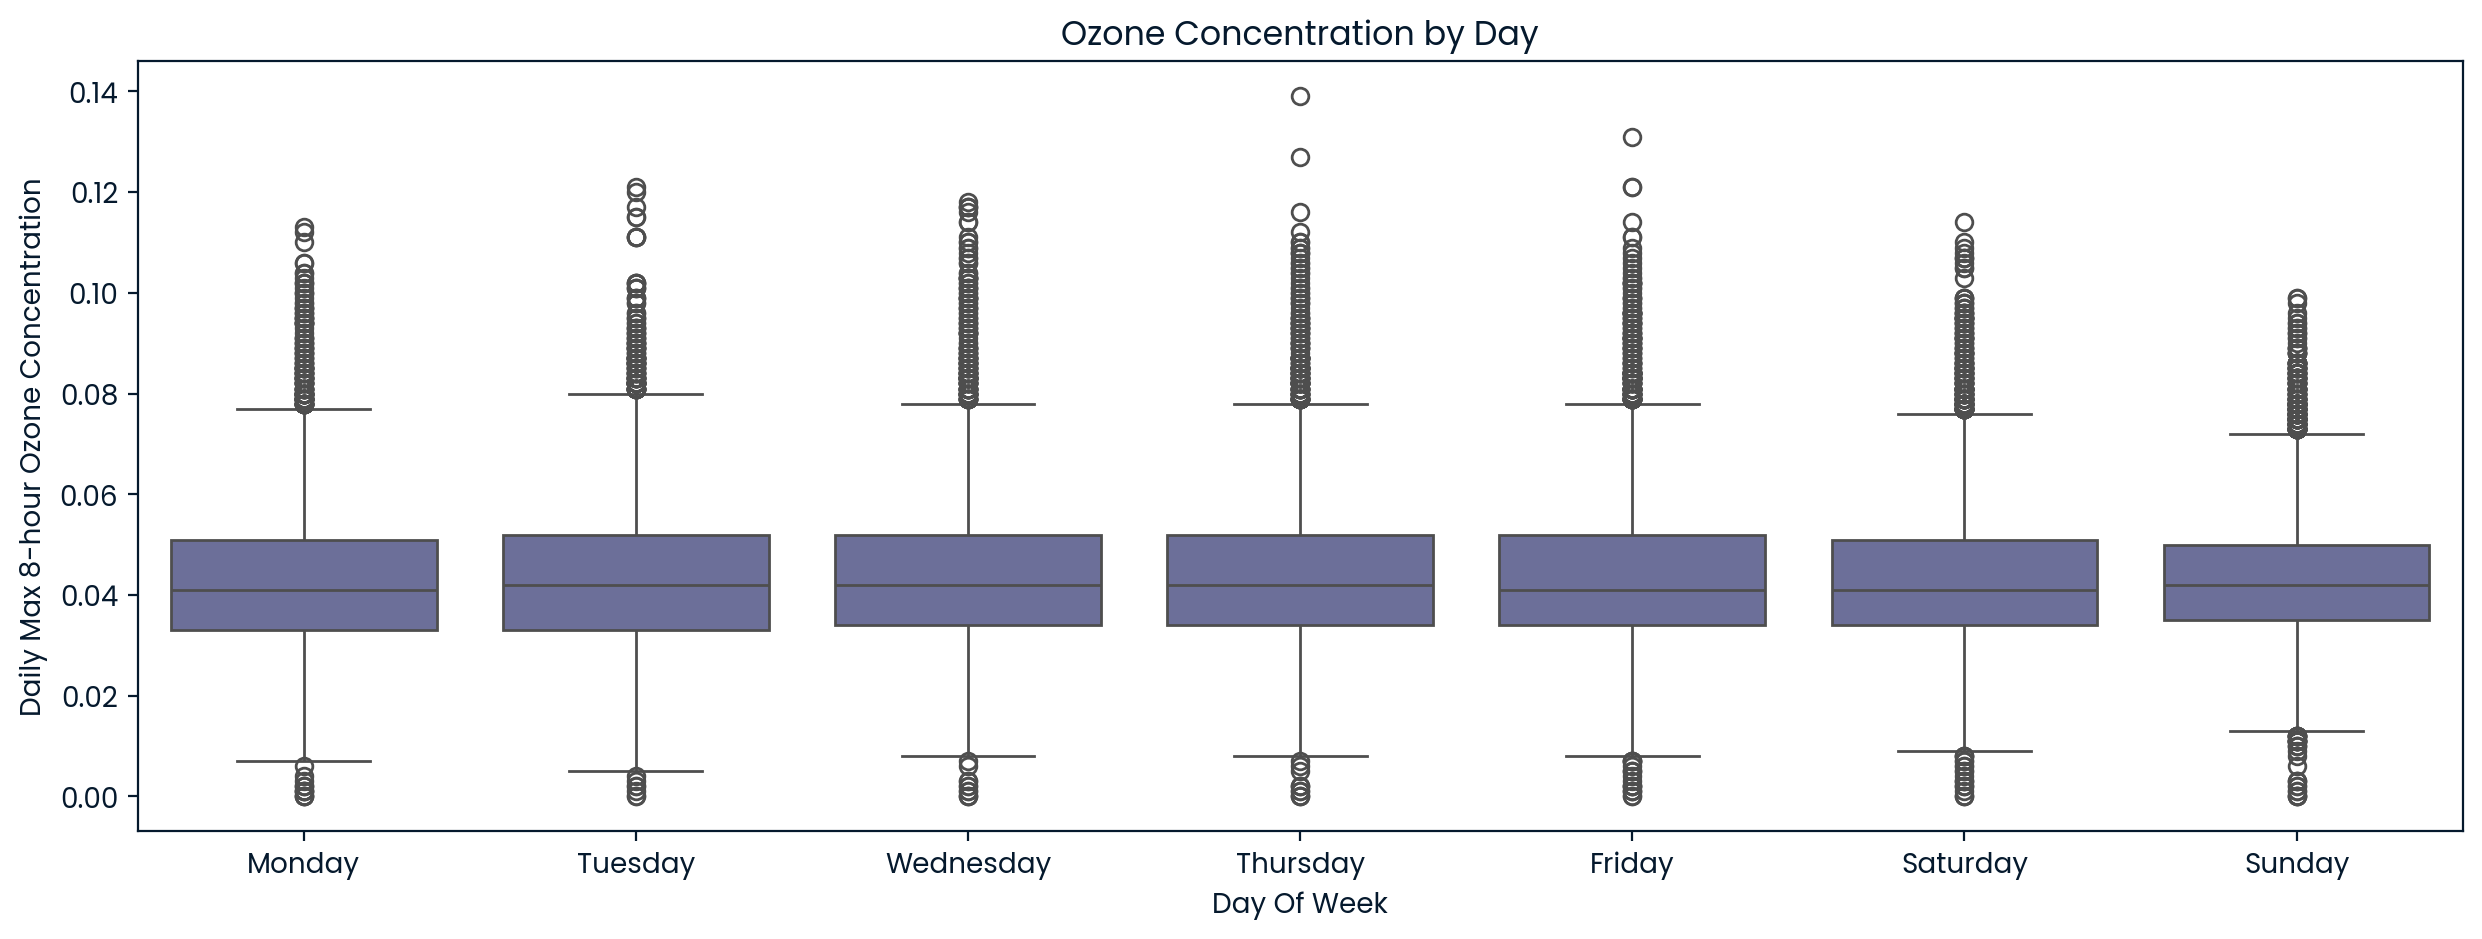

In [34]:
# categorize the days to ensure proper order 
df['Day Of Week'] = pd.Categorical(df['Day Of Week'], categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered = True)

# use a boxplot to visualize the distribution per day
plt.figure(figsize = (15, 5))
sns.boxplot(data = df, x= 'Day Of Week', y = 'Daily Max 8-hour Ozone Concentration')
plt.title('Ozone Concentration by Day')

### Key Insights:
- Weekdays and weekends have similar average ozone concentration levels as well as similar lows and highs
- All the days in the week have similar IQR ranges as well as outliers that tend to hover right above 0 and above or just right below 0.08


However, let's take a closer look and see if these findings are also consistent in counties. We can take a look again at our top 10 counties and use those as reference

In [53]:
# recall our dataframe with the top 10 counties (based on number of measurements)
top_counties

df_top_10_days = df[df['County'].isin(top_counties)]

# group by day and county to analyze average ozone concentration
df_day_weekend = df_top_10_days.groupby(['Day Of Week', 'County'])['Daily Max 8-hour Ozone Concentration'].mean().reset_index()
df_day_weekend

,Day Of Week,County,Daily Max 8-hour Ozone Concentration
0,Monday,Fresno,0.044664
1,Monday,Kern,0.047560
2,Monday,Los Angeles,0.047188
3,Monday,Placer,0.042539
4,Monday,Riverside,0.051155
...,...,...,...
65,Sunday,San Bernardino,0.054494
66,Sunday,San Diego,0.045422
67,Sunday,San Luis Obispo,0.039344
68,Sunday,Santa Barbara,0.033042


Line plot to show change in average ozone concetration for each county in the top 10 over the days of the week (Monday - Sunday)

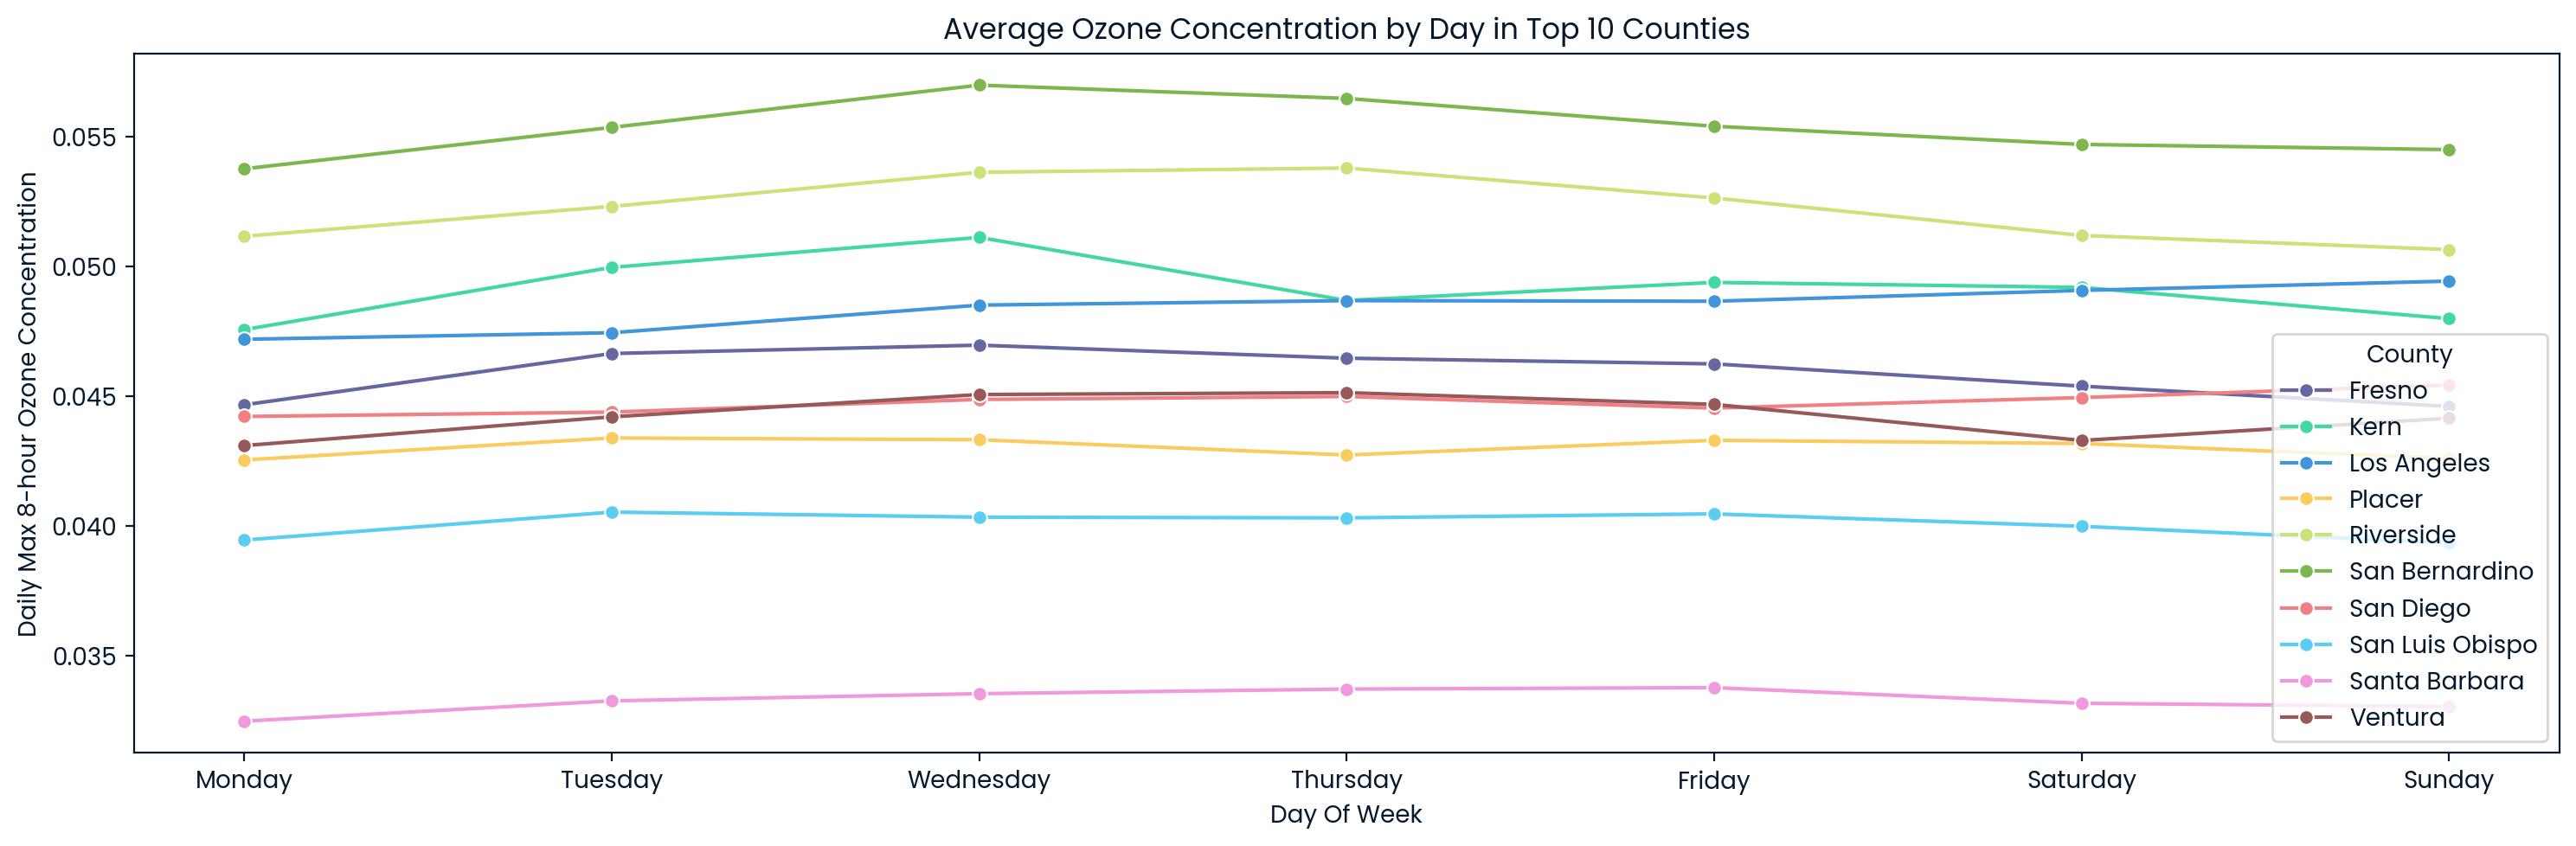

In [61]:
# use a line plot to show average ozone concentration by weekday for each county
plt.figure(figsize = (15, 5))
sns.lineplot(data = df_day_weekend, x = 'Day Of Week', y = 'Daily Max 8-hour Ozone Concentration', hue = 'County', marker = 'o')
plt.title('Average Ozone Concentration by Day in Top 10 Counties')
plt.tight_layout() # prevent the legend from overlapping the important stuff
plt.show()

### Key Insights:
- Average ozone concentration are generally stable with mild fluctuations across all days of the week
- Most notable exceptions are: peak on Wednesdays for San Bernardino, Riverside, and Kern counties. There is also a dip on Kern county's ozone concentration on Thursdays
- In general, seems like there is a *slight* upwards trend starting from Monday to Thursday, and gradually declines until Sunday. This may suggest that urban activity is highest during Monday to Thursdays on average in these counties

## Geospatial heatmap to show ozone concentration levels across counties ##

Analyze the average ozone concentration per county with a geospatial heatmap

In [19]:
# use average ozone concentration per county for geospatial heatmap
df_avg = df.groupby('County')['Daily Max 8-hour Ozone Concentration'].mean().reset_index()
df_avg 
# we'll use the average site latitude/longitude for each county because there are several sites per county

df_coordinates = df.groupby('County')[['Site Latitude', 'Site Longitude']].mean().reset_index()
df_coordinates

,County,Site Latitude,Site Longitude
0,Alameda,37.760409,-122.137156
1,Amador,38.342606,-120.764426
2,Butte,39.759759,-121.723508
3,Calaveras,38.201850,-120.680277
4,Colusa,39.189190,-121.998870
5,Contra Costa,37.900462,-121.983080
6,El Dorado,38.795283,-120.683199
7,Fresno,36.767931,-119.808350
8,Glenn,39.533870,-122.190834
9,Humboldt,40.776780,-124.179490


Merge the average ozone dataset and the latitude/longitude dataset to create heatmap

In [35]:
# now that we have our coordinates per county, we can merge the two datasets
df_merged = pd.merge(df_avg, df_coordinates, on = 'County')
df_merged

# proceed to create geospatial heatmap using plotly
import plotly.express as px 

fig = px.scatter_mapbox(
    df_merged,
    lat = 'Site Latitude', 
    lon = 'Site Longitude', 
    size = 'Daily Max 8-hour Ozone Concentration',
    color = 'Daily Max 8-hour Ozone Concentration',
    color_continuous_scale = px.colors.sequential.OrRd,
    size_max = 20,
    zoom = 5.5,
    mapbox_style = 'carto-positron',
    hover_name = 'County',
    title = 'Average Ozone Concentration by County',
    height = 1000
)

fig.show()

### Key Insights:
- Coastal counties like Santa Barbara and Sonoma tend to experience lower ozone concentrations, likely due to sea breezes and overall cleaner air flow from the ocean 
- Inland counties like Tulare and Kern tend to experience higher ozone concentrations, likely due to being downwind of emission sources from surrounding areas 
- There appears to be a general trend of increasing ozone concentrations toward Southern California. This may be due to factors like higher emissions from vehicles and industries (especially in large cities like Los Angeles)
